In [225]:
import pickle
import numpy as np
import evaluate
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict, Features, ClassLabel, Sequence, Value
from scipy.signal import resample
from tqdm import tqdm
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification, TrainingArguments, Trainer, pipeline

In [ ]:
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base")
feature_extractor.sampling_rate

In [4]:
def load_preprocessed_data(pickle_path, file_path):
    features, labels, trials = {}, {}, {}
    for session in file_path:
        data = pickle.load(open(f"{pickle_path}/{session}_raw.pickle", 'rb'))
        X, y, trial_idx = zip(*[(d[0], d[1], d[2]) for d in data])
        features[session] = np.array(X)
        labels[session] = np.array(y, dtype=int)
        trials[session] = np.array(trial_idx)

        non_zero_indices = [i for i, x in enumerate(features[session]) if not np.all(x == 0)]

        features[session] = features[session][non_zero_indices]
        labels[session] = labels[session][non_zero_indices]
        trials[session] = trials[session][non_zero_indices]

        # Sanity check
        assert len(features[session]) == len(labels[session]) == len(trials[session]), \
            f"Inconsistent data sizes for session {session}"

    return features, labels, trials

In [5]:
hc_acronyms = {'CA1', 'CA2', 'CA3', 'DG', 'VIS'}
acronyms_arr = np.array(sorted(list(hc_acronyms)))
acronyms_arr_num = np.arange(len(acronyms_arr))
label2id = {acr: str(i) for i, acr in enumerate(acronyms_arr)}
label2id

{'CA1': '0', 'CA2': '1', 'CA3': '2', 'DG': '3', 'VIS': '4'}

In [6]:
id2label = {str(i): acr for i, acr in enumerate(acronyms_arr)}
id2label

{'0': 'CA1', '1': 'CA2', '2': 'CA3', '3': 'DG', '4': 'VIS'}

In [7]:
pickle_path = "spectrogram/ibl"
file_path = ['4a45c8ba-db6f-4f11-9403-56e06a33dfa4']
features, labels, trials = load_preprocessed_data(pickle_path, file_path)
features = features.get(file_path[0])
labels = labels.get(file_path[0])
trials = trials.get(file_path[0])

trial_length = 60
train_tr_idx, test_tr_idx = train_test_split(range(trial_length), test_size=0.2, random_state=42)
train_idx = [idx for idx, val in enumerate(trials) if val in train_tr_idx]
test_idx = [idx for idx, val in enumerate(trials) if val not in train_tr_idx]

idx_train, idx_val = train_test_split(train_idx, test_size=0.25, random_state=42, stratify=labels[train_idx])

X_train, y_train = features[idx_train], labels[idx_train]
X_val, y_val = features[idx_val], labels[idx_val]
X_test, y_test = features[test_idx], labels[test_idx]

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

y_train = [str(label) for label in y_train]
y_val = [str(label) for label in y_val]
y_test = [str(label) for label in y_test]

In [8]:
unique_label = np.unique(labels)
unique_label

array([0, 1, 2, 3, 4])

In [9]:
def preprocess_data(signals, signal_sampling_rate):
    target_sampling_rate = 16000
    upsampled_signals = []

    for signal in signals:
        # Calculate the number of samples for the target sampling rate
        num_target_samples = int(len(signal) * target_sampling_rate / signal_sampling_rate)
        # Resample the signal
        upsampled_signal = resample(signal, num_target_samples)
        upsampled_signals.append(upsampled_signal)

    return np.array(upsampled_signals)

In [10]:
X_train_upsampled = preprocess_data(X_train, 2500)
X_val_upsampled = preprocess_data(X_val, 2500)
X_test_upsampled = preprocess_data(X_test, 2500)

In [11]:
print(X_train.shape, type(X_train))
print(X_train_upsampled.shape, type(X_train_upsampled))

(4968, 7500) <class 'numpy.ndarray'>
(4968, 48000) <class 'numpy.ndarray'>


In [12]:
custom_features = Features({
    'label': ClassLabel(num_classes=5, names=['CA1', 'CA2', 'CA3', 'DG', 'VIS']),
    'input_values': Sequence(feature=Value(dtype='float'), length=-1)
})

In [13]:
def create_dataset_dict(X_train, y_train, X_val, y_val, X_test, y_test):
    # Create individual datasets
    train_dict = {}
    train_dict["label"] = y_train
    train_dict["input_values"] = X_train.tolist()
    train_dataset = Dataset.from_dict(train_dict, features=custom_features)

    val_dict = {}
    val_dict["label"] = y_val
    val_dict["input_values"] = X_val.tolist()
    val_dataset = Dataset.from_dict(val_dict, features=custom_features)

    test_dict = {}
    test_dict["label"] = y_test
    test_dict["input_values"] = X_test.tolist()
    test_dataset = Dataset.from_dict(test_dict, features=custom_features)

    # Combine into a DatasetDict
    dataset_dict = DatasetDict({
        "train": train_dataset,
        "validation": val_dataset,
        "test": test_dataset
    })

    return dataset_dict

In [14]:
dataset_dict = create_dataset_dict(X_train_upsampled, y_train, X_val_upsampled, y_val, X_test_upsampled, y_test)
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['label', 'input_values'],
        num_rows: 4968
    })
    validation: Dataset({
        features: ['label', 'input_values'],
        num_rows: 1656
    })
    test: Dataset({
        features: ['label', 'input_values'],
        num_rows: 1656
    })
})

In [15]:
dataset_dict["train"].features

{'label': ClassLabel(names=['CA1', 'CA2', 'CA3', 'DG', 'VIS'], id=None),
 'input_values': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None)}

In [16]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=eval_pred.label_ids)

In [ ]:
print(id2label)
print(label2id)

In [ ]:
num_labels = len(id2label)
model = AutoModelForAudioClassification.from_pretrained(
    "facebook/wav2vec2-base", num_labels=num_labels, label2id=label2id, id2label=id2label
)

In [81]:
model

Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
import accelerate
print(accelerate.__version__)

In [ ]:
training_args = TrainingArguments(
    output_dir="lfp_ibl",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=32,
    num_train_epochs=20,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_dict["train"].with_format("torch"),
    eval_dataset=dataset_dict["validation"].with_format("torch"),
    processing_class=feature_extractor,
    compute_metrics=compute_metrics,
)

In [21]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.404100,1.271487,0.515700
2,1.119200,1.006188,0.633454
3,0.861100,0.712070,0.767512
4,0.696200,0.613733,0.813406
5,0.695500,0.632902,0.788647
6,0.566700,0.491556,0.842995
7,0.463400,0.449046,0.858696
8,0.455400,0.414065,0.859300
9,0.495800,0.470632,0.825483
10,0.410800,0.393086,0.870773


TrainOutput(global_step=780, training_loss=0.5094046036402384, metrics={'train_runtime': 23195.2808, 'train_samples_per_second': 4.284, 'train_steps_per_second': 0.034, 'total_flos': 2.70618088002048e+18, 'train_loss': 0.5094046036402384, 'epoch': 20.0})

In [ ]:
trainer.save_model("lfp_ibl")

In [34]:
trainer.evaluate(dataset_dict["train"].with_format("torch"))

{'eval_loss': 0.20079457759857178,
 'eval_accuracy': 0.9243156199677939,
 'eval_runtime': 105.2123,
 'eval_samples_per_second': 47.219,
 'eval_steps_per_second': 1.483,
 'epoch': 20.0}

In [35]:
trainer.evaluate(dataset_dict["validation"].with_format("torch"))

{'eval_loss': 0.2227412462234497,
 'eval_accuracy': 0.9190821256038647,
 'eval_runtime': 33.8025,
 'eval_samples_per_second': 48.99,
 'eval_steps_per_second': 1.538,
 'epoch': 20.0}

In [33]:
trainer.evaluate(dataset_dict["test"].with_format("torch"))

{'eval_loss': 0.3607017695903778,
 'eval_accuracy': 0.8798309178743962,
 'eval_runtime': 35.4311,
 'eval_samples_per_second': 46.739,
 'eval_steps_per_second': 1.468,
 'epoch': 20.0}

In [36]:
test_preds = trainer.predict(dataset_dict["test"].with_format("torch"))

In [40]:
test_preds

PredictionOutput(predictions=array([[-0.7269445 , -0.7539699 , -2.1520438 , -0.7458312 ,  4.0325656 ],
       [ 3.2156858 , -1.081476  , -1.9458416 , -1.3838729 ,  0.26477298],
       [ 0.45146573, -0.9631059 , -2.4465408 , -1.0671183 ,  3.399367  ],
       ...,
       [ 3.8067622 , -0.8764236 , -1.0337611 , -1.253569  , -1.4421959 ],
       [ 3.7679658 , -0.90823734, -1.1954175 , -1.2727777 , -1.2280096 ],
       [ 3.5584013 , -1.0090119 , -1.6000863 , -1.3343241 , -0.5140723 ]],
      dtype=float32), label_ids=array([4, 4, 4, ..., 0, 0, 0], dtype=int64), metrics={'test_loss': 0.3607017695903778, 'test_accuracy': 0.8798309178743962, 'test_runtime': 35.0702, 'test_samples_per_second': 47.22, 'test_steps_per_second': 1.483})

In [244]:
train_labs = test_preds[1]
train_labs

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x00000265DFAF6A10>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 26790797610, raw_cell="train_labs = test_preds[1]
train_labs
" store_history=True silent=False shell_futures=True cell_id=None>,),kwargs {}:


ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host

array([4, 4, 4, ..., 0, 0, 0], dtype=int64)

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x00000265DFAF6A10>> (for post_run_cell), with arguments args (<ExecutionResult object at 26790794a60, execution_count=244 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 26790797610, raw_cell="train_labs = test_preds[1]
train_labs
" store_history=True silent=False shell_futures=True cell_id=None> result=array([4, 4, 4, ..., 0, 0, 0], dtype=int64)>,),kwargs {}:


ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host

In [60]:
test_preds[2]['test_accuracy']

0.8798309178743962

In [64]:
predicted_logits = test_preds[0]
predicted_logits.shape

(1656, 5)

In [65]:
y_test = np.array(y_test)
y_test = y_test.astype(int)
y_test.shape

(1656,)

In [66]:
print(type(y_test[0]), type(predicted_logits[0]))

<class 'numpy.int32'> <class 'numpy.ndarray'>


In [68]:
# Parse logits and see if the predicted labels match the true labels
predicted_labels = np.argmax(predicted_logits, axis=1)
predicted_labels

array([4, 0, 4, ..., 0, 0, 0], dtype=int64)

In [72]:
correct = 0
total = 0
for i in range(len(y_test)):
    if y_test[i] == predicted_labels[i]:
        correct += 1
    total += 1

print(f"Accuracy: {correct/total}")

Accuracy: 0.8798309178743962


In [140]:
projector_output = None
classifier_input_first = None
classifier_input_whole = None
classifier_output = None

def projector_hook(module, input, output):
    global projector_output
    projector_output = output

def classifier_hook(module, input, output):
    global classifier_input_first, classifier_input_whole, classifier_output
    classifier_input_first = input[0]
    classifier_input_whole = input
    classifier_output = output

projector_hook_handle = model.projector.register_forward_hook(projector_hook)
classifier_hook_handle = model.classifier.register_forward_hook(classifier_hook)

In [137]:
y_test.shape

(1656,)

In [141]:
trainer.predict(dataset_dict["test"].with_format("torch"))

PredictionOutput(predictions=array([[-0.7269445 , -0.7539699 , -2.1520438 , -0.7458312 ,  4.0325656 ],
       [ 3.2156858 , -1.081476  , -1.9458416 , -1.3838729 ,  0.26477298],
       [ 0.45146573, -0.9631059 , -2.4465408 , -1.0671183 ,  3.399367  ],
       ...,
       [ 3.8067622 , -0.8764236 , -1.0337611 , -1.253569  , -1.4421959 ],
       [ 3.7679658 , -0.90823734, -1.1954175 , -1.2727777 , -1.2280096 ],
       [ 3.5584013 , -1.0090119 , -1.6000863 , -1.3343241 , -0.5140723 ]],
      dtype=float32), label_ids=array([4, 4, 4, ..., 0, 0, 0], dtype=int64), metrics={'test_loss': 0.3607017695903778, 'test_accuracy': 0.8798309178743962, 'test_runtime': 56.5402, 'test_samples_per_second': 29.289, 'test_steps_per_second': 0.92})

In [122]:
y_test.shape

(1656,)

In [146]:
print("Projector Output Shape:", projector_output.shape)
print("Classifier Input First Shape:", classifier_input_first.shape)
print("Classifier Input Whole Shape:", len(classifier_input_whole))
print("Classifier Output Shape:", classifier_output.shape)

Projector Output Shape: torch.Size([24, 149, 256])
Classifier Input First Shape: torch.Size([24, 256])
Classifier Input Whole Shape: 1
Classifier Output Shape: torch.Size([24, 5])


In [170]:
classifier_input_whole[0].detach().cpu().numpy()

array([[ 0.795007  ,  0.7238999 ,  1.0286723 , ...,  0.69866204,
        -0.5345788 , -1.2240506 ],
       [ 0.79806715,  0.7353197 ,  1.021223  , ...,  0.7067088 ,
        -0.53643376, -1.2319596 ],
       [ 0.7243787 ,  0.7860856 ,  0.9679852 , ...,  0.7167817 ,
        -0.5710744 , -1.2291523 ],
       ...,
       [ 0.82878065,  0.69948983,  1.0450482 , ...,  0.6936883 ,
        -0.49673635, -1.2344509 ],
       [ 0.77135843,  0.7406193 ,  1.0021535 , ...,  0.70415664,
        -0.54687876, -1.2243173 ],
       [ 0.57915336,  0.88056606,  0.824217  , ...,  0.7628738 ,
        -0.6754354 , -1.1763122 ]], dtype=float32)

In [132]:
po = projector_output.detach().cpu().numpy()
po.shape

(24, 149, 256)

In [133]:
po[0].shape

(149, 256)

In [147]:
classifier_input_first[0]

tensor([ 0.7950,  0.7239,  1.0287, -1.2248, -1.3448, -0.3008,  0.8214,  0.3795,
        -0.4438,  0.1331,  1.0353, -0.3598, -0.5653,  0.2021, -0.8322,  0.4967,
         0.4210, -1.2554, -0.7734, -0.1752, -0.6706,  1.4340,  1.5848, -0.0517,
        -0.4438, -0.9616, -0.2122,  0.0731, -0.6622, -0.9510,  0.5133, -0.8536,
         0.6199, -1.1930, -1.2013,  0.2344, -0.1092,  0.4770, -0.5474, -0.1432,
         0.7418, -1.3989, -0.6076,  1.1649,  1.1075,  0.1303, -0.5897,  1.2762,
        -0.5562, -1.5668,  0.2637, -1.0752,  0.0984,  1.2397,  0.9660, -0.4445,
        -0.2833,  0.7990, -0.2604, -0.2560,  0.3569,  0.8479,  0.3168,  0.3307,
         1.0735, -0.7182, -0.0987, -1.3530,  1.0366,  0.2757, -0.5695, -1.2026,
        -0.7079,  0.6047,  1.2683,  0.6941,  0.6484, -0.7579,  0.0123,  1.1438,
         0.3915,  0.7806, -0.8553, -0.1267,  1.2138,  1.0228,  0.8500, -0.3573,
         0.3680, -0.1180,  0.4174,  0.5824, -0.1027,  0.3567, -0.5281,  0.3470,
         0.2630,  1.0314,  0.3437, -0.69

In [166]:
first_obj = projector_output[0].detach().cpu().numpy()
print(f" {first_obj.T[0].sum()/149:.4f}, \n {first_obj.T[1].sum()/149:.4f}, \n {first_obj.T[2].sum()/149:.4f} ")

 0.7950, 
 0.7239, 
 1.0287 


In [120]:
projector_output[0].detach().cpu().numpy()

array([[ 0.79405427,  0.7188161 ,  1.0338577 , ...,  0.6818747 ,
        -0.5576769 , -1.2313784 ],
       [ 0.7900889 ,  0.7155317 ,  1.0472676 , ...,  0.6907457 ,
        -0.560961  , -1.2157681 ],
       [ 0.8138164 ,  0.731464  ,  1.0297263 , ...,  0.70641804,
        -0.5374629 , -1.2160902 ],
       ...,
       [ 0.8008037 ,  0.72066134,  1.0179323 , ...,  0.69278485,
        -0.5189241 , -1.2021343 ],
       [ 0.78585786,  0.71278644,  1.0329617 , ...,  0.6881778 ,
        -0.5162943 , -1.2135303 ],
       [ 0.7875775 ,  0.71462184,  1.042853  , ...,  0.68283063,
        -0.51945186, -1.2195115 ]], dtype=float32)

In [121]:
projector_output[14].detach().cpu().numpy()

array([[ 0.7841679 ,  0.7159565 ,  1.0373025 , ...,  0.68156093,
        -0.57191324, -1.2367702 ],
       [ 0.79816407,  0.7249142 ,  1.0301586 , ...,  0.7128757 ,
        -0.54538417, -1.228202  ],
       [ 0.7946225 ,  0.7318517 ,  1.0144849 , ...,  0.6963305 ,
        -0.54164726, -1.2141358 ],
       ...,
       [ 0.7405305 ,  0.7241335 ,  1.0489197 , ...,  0.6754989 ,
        -0.5846619 , -1.2606881 ],
       [ 0.72694826,  0.7282599 ,  1.0444872 , ...,  0.6814003 ,
        -0.5645851 , -1.2584931 ],
       [ 0.7253745 ,  0.72317827,  1.0425118 , ...,  0.6835704 ,
        -0.5634048 , -1.2410835 ]], dtype=float32)

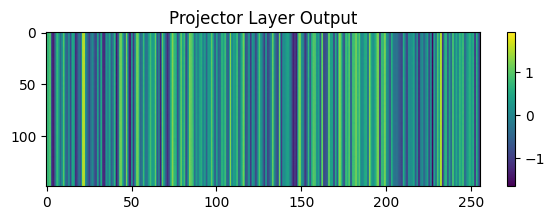

In [134]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 2))
plt.imshow(projector_output[0].detach().cpu().numpy(), aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Projector Layer Output")
plt.savefig("projector_layer_output_0.png")
plt.show()

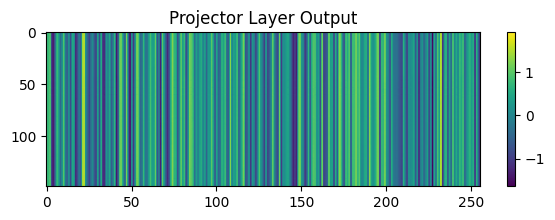

In [135]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 2))
plt.imshow(projector_output[5].detach().cpu().numpy(), aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Projector Layer Output")
plt.savefig("projector_layer_output_5.png")
plt.show()

In [220]:
# Count of each label in the test set
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 672, 1: 48, 2: 384, 3: 72, 4: 480}

In [228]:
embeddings = []
labels = []
classes = np.unique(y_test)

# Track progress through the dataset
current_index = 0
batch_size = 30

# Flatten the dataset for easier sequential access
full_data = X_test_upsampled
full_labels = y_test

# Continue until the entire dataset is processed
while current_index < len(full_data):
    # Take the next batch of 30 samples
    end_index = min(current_index + batch_size, len(full_data))
    batch_data = full_data[current_index:end_index]
    batch_labels = full_labels[current_index:end_index]

    # Update the current index
    current_index = end_index

    # Convert batch to required format
    batch_dict = {"label": batch_labels, "input_values": batch_data.tolist()}
    batch_dataset = Dataset.from_dict(batch_dict, features=custom_features)

    # Get predictions
    small_predictions = trainer.predict(batch_dataset.with_format("torch"))
    print(small_predictions[2]['test_accuracy'])

    # Get embeddings for the current batch
    temp_embeddings = classifier_input_first.cpu().detach().numpy()

    # Save embeddings and labels
    embeddings.extend(temp_embeddings)
    labels.extend(batch_labels)

0.8333333333333334


1.0


1.0


1.0


1.0


1.0


1.0


1.0


0.9666666666666667


0.9666666666666667


0.9666666666666667


0.9333333333333333


0.9333333333333333


1.0


1.0


1.0


1.0


1.0


0.9


0.9333333333333333


0.8333333333333334


0.8333333333333334


0.8333333333333334


0.9666666666666667


1.0


1.0


1.0


1.0


0.8


0.0


0.0


0.0


0.1


0.6333333333333333


0.9333333333333333


1.0


1.0


1.0


1.0


1.0


1.0


0.9666666666666667


0.9333333333333333


0.9333333333333333


0.9


0.9333333333333333


0.9333333333333333


0.9333333333333333


0.9333333333333333


0.9333333333333333


0.9333333333333333


0.9333333333333333


0.9


0.9333333333333333


0.9


1.0


In [233]:
# Track progress through the dataset
current_index = 0
batch_size = 30

# Flatten the dataset for easier sequential access
full_data = X_train_upsampled
full_labels = y_train

# Continue until the entire dataset is processed
while current_index < len(full_data):
    # Take the next batch of 30 samples
    end_index = min(current_index + batch_size, len(full_data))
    batch_data = full_data[current_index:end_index]
    batch_labels = full_labels[current_index:end_index]

    # Update the current index
    current_index = end_index

    # Convert batch to required format
    batch_dict = {"label": batch_labels, "input_values": batch_data.tolist()}
    batch_dataset = Dataset.from_dict(batch_dict, features=custom_features)

    # Get predictions
    small_predictions = trainer.predict(batch_dataset.with_format("torch"))
    print(small_predictions[2]['test_accuracy'])

    # Get embeddings for the current batch
    temp_embeddings = classifier_input_first.cpu().detach().numpy()

    # Save embeddings and labels
    embeddings.extend(temp_embeddings)
    labels.extend(batch_labels)

0.9


0.9333333333333333


0.9333333333333333


0.8666666666666667


0.8666666666666667


0.8666666666666667


0.9


0.9333333333333333


0.9333333333333333


0.9333333333333333


0.8


0.9666666666666667


0.9666666666666667


0.9


0.9666666666666667


0.9333333333333333


0.8666666666666667


0.8666666666666667


0.9


0.9333333333333333


0.9666666666666667


0.9


0.9333333333333333


0.9666666666666667


0.9333333333333333


0.8333333333333334


0.9666666666666667


1.0


0.8333333333333334


0.9333333333333333


0.9


0.9666666666666667


0.8666666666666667


0.9


0.9


0.9666666666666667


0.8333333333333334


0.9


0.8666666666666667


0.8666666666666667


0.9666666666666667


0.9666666666666667


0.9


1.0


1.0


1.0


0.9333333333333333


0.9666666666666667


0.9666666666666667


0.9333333333333333


0.9


0.9333333333333333


0.9333333333333333


0.9666666666666667


0.9


0.9666666666666667


1.0


0.8666666666666667


0.8666666666666667


0.8666666666666667


0.9


0.9


0.9


0.9


0.9666666666666667


0.8333333333333334


0.9333333333333333


0.9333333333333333


0.8666666666666667


0.9


0.9333333333333333


0.9333333333333333


0.9333333333333333


0.9333333333333333


0.9333333333333333


0.9333333333333333


0.8666666666666667


0.9


0.9333333333333333


0.8666666666666667


0.9


0.9333333333333333


0.9


0.9333333333333333


0.9


0.9333333333333333


0.9666666666666667


0.8333333333333334


0.9666666666666667


0.9


0.8666666666666667


0.9


0.9333333333333333


1.0


0.9666666666666667


0.9


0.9333333333333333


0.9666666666666667


0.9333333333333333


0.9


0.9666666666666667


0.9333333333333333


0.9666666666666667


0.9


0.9333333333333333


0.9666666666666667


0.9


0.9666666666666667


0.9666666666666667


0.9


0.9666666666666667


0.9666666666666667


0.9666666666666667


0.9


0.8333333333333334


0.9666666666666667


0.9333333333333333


0.9666666666666667


0.9333333333333333


0.9666666666666667


0.9333333333333333


0.8666666666666667


0.9666666666666667


0.9333333333333333


0.8666666666666667


0.9333333333333333


0.9333333333333333


0.9333333333333333


0.8666666666666667


0.9


1.0


1.0


0.9333333333333333


0.9333333333333333


0.9


0.9666666666666667


0.8666666666666667


0.9333333333333333


0.9


1.0


0.9666666666666667


0.9333333333333333


0.9


0.8666666666666667


0.8666666666666667


0.9666666666666667


0.8666666666666667


0.9333333333333333


0.9


0.9333333333333333


0.9666666666666667


0.9666666666666667


0.9666666666666667


0.9


0.9666666666666667


0.9666666666666667


0.9333333333333333


0.9


0.9


0.9666666666666667


0.9666666666666667


0.9


0.9333333333333333


0.9666666666666667


0.9333333333333333


0.8888888888888888


In [238]:
# Track progress through the dataset
current_index = 0
batch_size = 30

# Flatten the dataset for easier sequential access
full_data = X_val_upsampled
full_labels = y_val

# Continue until the entire dataset is processed
while current_index < len(full_data):
    # Take the next batch of 30 samples
    end_index = min(current_index + batch_size, len(full_data))
    batch_data = full_data[current_index:end_index]
    batch_labels = full_labels[current_index:end_index]

    # Update the current index
    current_index = end_index

    # Convert batch to required format
    batch_dict = {"label": batch_labels, "input_values": batch_data.tolist()}
    batch_dataset = Dataset.from_dict(batch_dict, features=custom_features)

    # Get predictions
    small_predictions = trainer.predict(batch_dataset.with_format("torch"))
    print(small_predictions[2]['test_accuracy'])

    # Get embeddings for the current batch
    temp_embeddings = classifier_input_first.cpu().detach().numpy()

    # Save embeddings and labels
    embeddings.extend(temp_embeddings)
    labels.extend(batch_labels)

0.8666666666666667


0.9


0.8666666666666667


0.9


0.9333333333333333


0.9666666666666667


0.9333333333333333


0.9


0.7666666666666667


0.9666666666666667


0.9666666666666667


0.9333333333333333


0.9666666666666667


0.9666666666666667


0.9


0.9


0.8333333333333334


0.9666666666666667


0.9


1.0


0.9


1.0


0.8666666666666667


0.9333333333333333


0.9


0.9


0.9333333333333333


0.9


0.8666666666666667


0.9


0.9


0.8333333333333334


0.9333333333333333


0.9333333333333333


0.9333333333333333


0.9333333333333333


1.0


0.9333333333333333


0.9333333333333333


0.9666666666666667


0.9666666666666667


0.9


0.9


0.9666666666666667


0.9333333333333333


0.8666666666666667


0.9666666666666667


0.8


0.9333333333333333


0.9666666666666667


0.9666666666666667


0.9


0.9333333333333333


0.9


0.9


1.0


In [239]:
len(embeddings), len(labels)

(8280, 8280)

In [240]:
pca = PCA(n_components=2)
reduced_embeddings_2d = pca.fit_transform(embeddings)

df_2d = pd.DataFrame({
    "PC1": reduced_embeddings_2d[:, 0],
    "PC2": reduced_embeddings_2d[:, 1],
    "Label": labels
})

fig_2d = px.scatter(
    df_2d,
    x="PC1",
    y="PC2",
    color=df_2d["Label"].astype(str),
    title="2D PCA of Embeddings",
    labels={"Label": "Class Label"}
)

fig_2d.write_html("combined_pca_2d_visualization.html")
print("2D visualization saved as pca_2d_visualization.html")

2D visualization saved as pca_2d_visualization.html


In [241]:
pca_3d = PCA(n_components=3)
reduced_embeddings_3d = pca_3d.fit_transform(embeddings)

df_3d = pd.DataFrame({
    "PC1": reduced_embeddings_3d[:, 0],
    "PC2": reduced_embeddings_3d[:, 1],
    "PC3": reduced_embeddings_3d[:, 2],
    "Label": labels
})

fig_3d = px.scatter_3d(
    df_3d,
    x="PC1",
    y="PC2",
    z="PC3",
    color=df_3d["Label"].astype(str),  # Convert labels to string for discrete coloring
    title="3D PCA of Embeddings",
    labels={"Label": "Class Label"}
)

fig_3d.write_html("combined_pca_3d_visualization.html")
print("3D visualization saved as pca_3d_visualization.html")

3D visualization saved as pca_3d_visualization.html
